In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale, StandardScaler
from scipy.stats import zscore

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors


In [5]:
# Load data
tested = pd.read_csv("data/tested_molecules.csv")
tested.head()

,SMILES,PKM2_inhibition,ERK2_inhibition
0,C=C(C)c1nc(N)nc(N)n1,0,0
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0
2,C=CCNC(=O)CCCC(=O)NCC=C,0,0
3,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0
4,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0


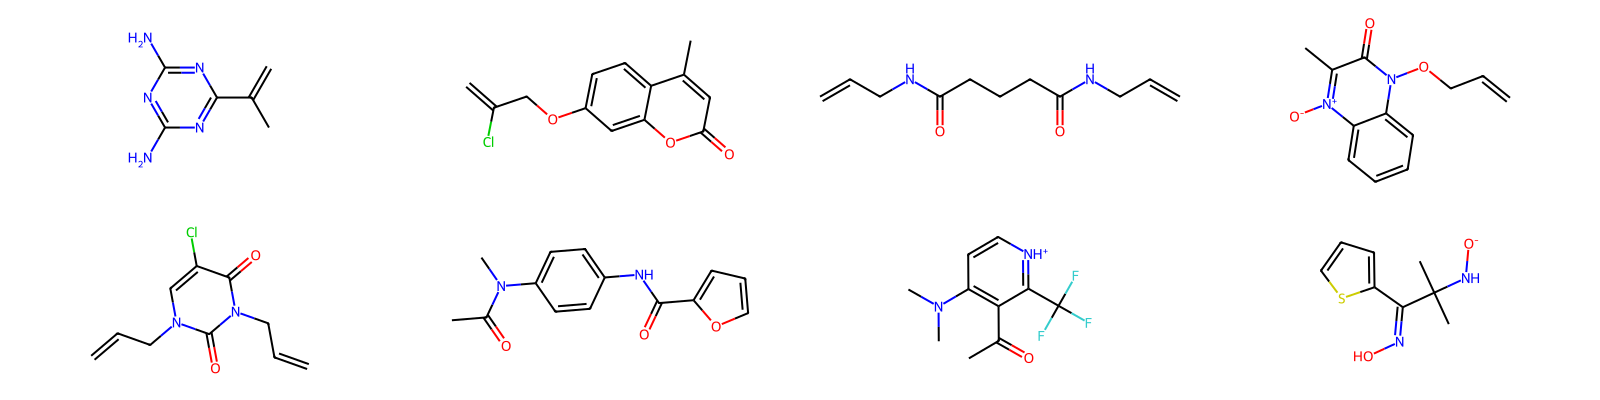

In [276]:
smiles = tested['SMILES']
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
Draw.MolsToGridImage(mols[0:8], molsPerRow=4, subImgSize=(400, 200))

In [7]:
MoleculeDescriptors.MolecularDescriptorCalculator(['fr_ketone']).GetDescriptorSummaries()

['Number of ketones']

In [8]:
# 1. Dataset preparation with RDKit, e.g., calculation of various types of molecular descriptors.

In [9]:
# 2D Descriptors
desc_list = [x[0] for x in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_list)
rdkit_desc = [calc.CalcDescriptors(m) for m in mols]  # our rdkit descriptors: 1116 rows by 210 cols

# Create 2d descriptor dataframe
desc_names = calc.GetDescriptorNames()
df_desc_2d = pd.DataFrame(rdkit_desc, index = smiles, columns=desc_names)
df_desc_2d.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
SMILES,,,,,,,,,,,,,,,,,,,,,
C=C(C)c1nc(N)nc(N)n1,5.313889,5.313889,0.120833,0.120833,0.592228,9.545455,151.173,142.101,151.085795,58,...,0,0,0,0,0,0,0,0,0,0
C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,11.238954,11.238954,0.225308,-0.366756,0.785414,10.470588,250.681,239.593,250.039672,88,...,0,0,0,0,0,0,0,0,0,0
C=CCNC(=O)CCCC(=O)NCC=C,11.090706,11.090706,0.049610,-0.049610,0.581062,9.066667,210.277,192.133,210.136828,84,...,0,0,0,0,0,0,0,0,0,0
C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,11.892238,11.892238,0.076632,-0.457824,0.441090,10.411765,232.239,220.143,232.084792,88,...,0,0,0,0,0,0,0,0,0,0
C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,11.693580,11.693580,0.012315,-0.498260,0.720343,9.933333,226.663,215.575,226.050905,80,...,0,0,0,0,0,0,0,0,0,0


In [277]:
# Binary (Morgan) ECFP6 fingerprints
radius = 3  # 2 for similarity exploration, 3 for ML
nBits = 1024  # 2048 is default, 1024 is also fine

# Calculate binary ECFP6 fingerprints:
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(m , radius = radius, nBits = nBits) for m in mols]

# Create fingerprint dataframe where each column represents a bit
fprint_cols = [f'Bit_{i}' for i in range(1, nBits + 1)]
fprint_bits = [list(x) for x in fingerprints]
df_fprint = pd.DataFrame(fprint_bits, index = smiles, columns = fprint_cols)
df_fprint.head()

,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,Bit_10,...,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023,Bit_1024
SMILES,,,,,,,,,,,,,,,,,,,,,
C=C(C)c1nc(N)nc(N)n1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
C=CCNC(=O)CCCC(=O)NCC=C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# MACCS keys

maccs_keys = np.array([MACCSkeys.GenMACCSKeys(m) for m in mols])
col_name = [f'feature_{i}' for i in range(1, len(maccs_keys[0]) + 1)]
# Create MACCS dataframe where each column corresponds to a MACCS feature (structural feature)
df_maccs = pd.DataFrame(data = maccs_keys, index = smiles, columns = col_name)

df_maccs.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167
SMILES,,,,,,,,,,,,,,,,,,,,,
C=C(C)c1nc(N)nc(N)n1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0
C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
C=CCNC(=O)CCCC(=O)NCC=C,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,1,0,0
C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,0
C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0


In [12]:
# 2. Exploratory data analysis, outlier analysis, and descriptor selection.

In [13]:
def find_corr_cols(df, threshold):
    # Find column pairs for which correlation > threshold
    corr_ma = df.corr()  # correlation matrix; shape: (210, 210)
    col_corr = set()  # set of tuples containing column names for which corr > threshold
    for i in range(0, len(corr_ma.columns)):
        for j in range(0, i):
            if corr_ma.iloc[i, j] >= threshold:
                col1_name, col2_name = corr_ma.columns[i], corr_ma.columns[j]
                if col1_name != col2_name:
                    col_corr.add((col1_name, col2_name))
    return col_corr

def make_corr_dict(col_corr):
    # Make dictionary with as key the column name and as value the number of times the key is in a highly correlated pair.
    d = {}
    for (i, j) in col_corr:
        if i not in d.keys():
            d[i] = 1
        else:
            d[i] += 1
        if j not in d.keys():
            d[j] = 1
        else:
            d[j] += 1
    # Sort dictionary keys in descending value order
    d = dict(sorted(d.items(), key=lambda item: item[1])[::-1])
    return d


In [14]:
# Find highly correlated variables

# 2D Descriptors
d_corr_desc_2d = make_corr_dict(find_corr_cols(df_desc_2d, 0.95))
print(list(d_corr_desc_2d.keys())[0:5])  # print top 5 highly correlated variables

# Binary fingerprints
d_corr_fprint = make_corr_dict(find_corr_cols(df_fprint, 0.95))
print(list(d_corr_fprint.keys())[0:5])

# MACCS Keys
d_corr_maccs = make_corr_dict(find_corr_cols(df_maccs, 0.95))
print(list(d_corr_maccs.keys())[0:5])

['NumValenceElectrons', 'Chi0v', 'LabuteASA', 'HeavyAtomCount', 'Chi0']
[]
['feature_52', 'feature_56', 'feature_62', 'feature_61', 'feature_59']


### Cleaning 2D descriptor data

 Dropped 23 single value columns
 Dropped 59 columns of higher than 0.8 correlation
 Reduced data by 39.05% to 128 columns


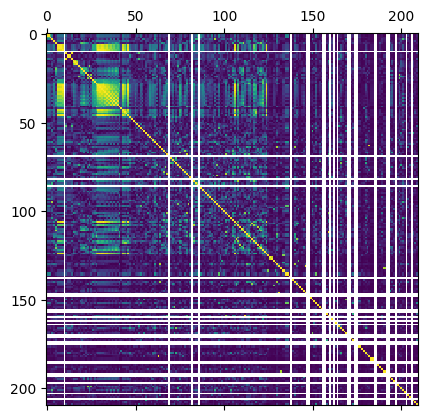

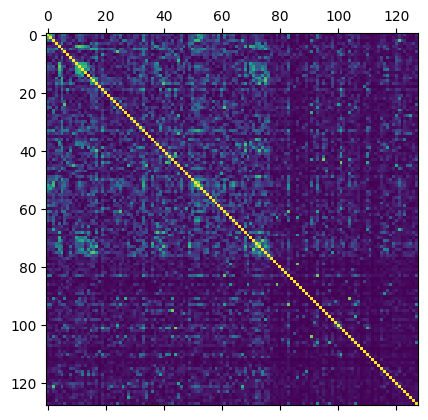

In [15]:
df = df_desc_2d.copy()
single_value_columns = [col for col in df.columns if len(set(df[col])) == 1]
df.drop(single_value_columns, axis=1, inplace=True)

# Create correlation matrix
corr_matrix = df.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features with correlation greater than threshold
threshold = 0.8
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
# Drop features 
df.drop(to_drop, axis=1, inplace=True)
# Show changes to columns
print(f" Dropped {len(single_value_columns)} single value columns\n",
      f"Dropped {len(to_drop)} columns of higher than {threshold} correlation\n",
      f"Reduced data by {(len(df_desc_2d.columns) - len(df.columns)) / len(df_desc_2d.columns)*100:.2f}% to {len(df.columns)} columns")
# Show old and new correlation matrix
plt.matshow(df_desc_2d.corr().abs())
plt.matshow(df.corr().abs())
plt.show()
# Copy cleaned df for saving
df_cleaned_2d = df.copy()

### Cleaning MACCS data

 Dropped 24 single value columns
 Dropped 26 columns of higher than 0.8 correlation
 Reduced data by 29.94% to 117 columns


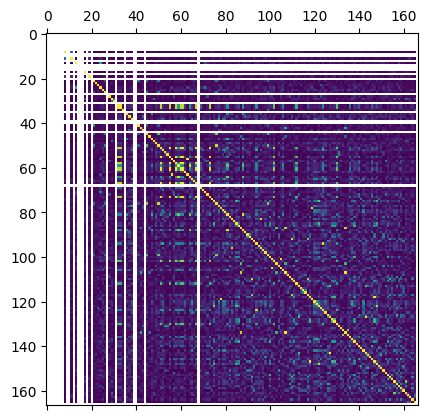

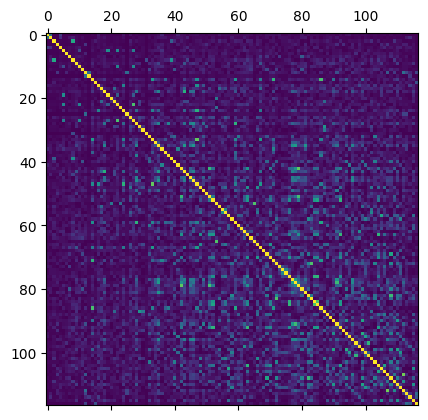

In [16]:
df = df_maccs.copy()
single_value_columns = [col for col in df.columns if len(set(df[col])) == 1]
df.drop(single_value_columns, axis=1, inplace=True)

# Create correlation matrix
corr_matrix = df.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features with correlation greater than threshold
threshold = 0.8
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
# Drop features 
df.drop(to_drop, axis=1, inplace=True)
# Show changes to columns
print(f" Dropped {len(single_value_columns)} single value columns\n",
      f"Dropped {len(to_drop)} columns of higher than {threshold} correlation\n",
      f"Reduced data by {(len(df_maccs.columns) - len(df.columns)) / len(df_maccs.columns)*100:.2f}% to {len(df.columns)} columns")
# Show old and new correlation matrix
plt.matshow(df_maccs.corr().abs())
plt.matshow(df.corr().abs())
plt.show()
# Copy cleaned df for saving
df_cleaned_maccs = df.copy()

### Cleaning Fingerprint data

 Dropped 0 single value columns
 Dropped 1 columns of higher than 0.8 correlation
 Reduced data by 0.10% to 1023 columns


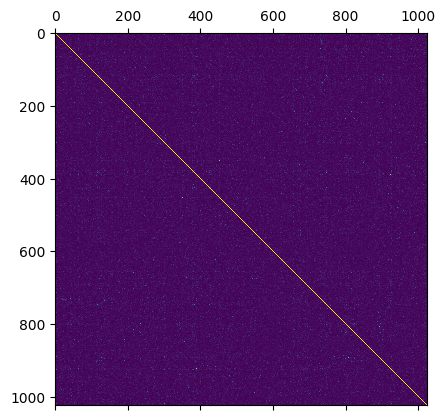

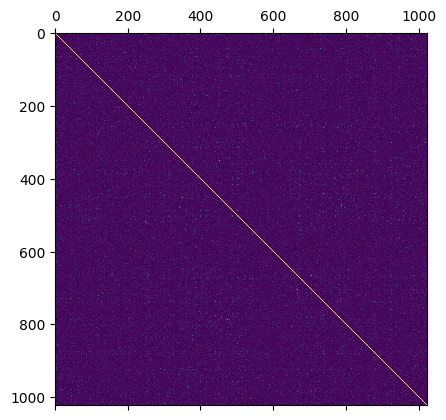

In [278]:
df = df_fprint.copy()
single_value_columns = [col for col in df.columns if len(set(df[col])) == 1]
df.drop(single_value_columns, axis=1, inplace=True)

# Create correlation matrix
corr_matrix = df.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features with correlation greater than threshold
threshold = 0.8
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
# Drop features 
df.drop(to_drop, axis=1, inplace=True)
# Show changes to columns
print(f" Dropped {len(single_value_columns)} single value columns\n",
      f"Dropped {len(to_drop)} columns of higher than {threshold} correlation\n",
      f"Reduced data by {(len(df_fprint.columns) - len(df.columns)) / len(df_fprint.columns)*100:.2f}% to {len(df.columns)} columns")
# Show old and new correlation matrix
plt.matshow(df_fprint.corr().abs())
plt.matshow(df.corr().abs())
plt.show()
# Copy cleaned df for saving
df_cleaned_fprint = df.copy()

### Saving cleaned data

In [279]:
df_cleaned_2d.to_csv("data/cleaned_2d_descriptors.csv")
df_cleaned_maccs.to_csv("data/cleaned_maccs_keys.csv")
df_cleaned_fprint.to_csv("data/cleaned_fingerprints.csv")

In [19]:
# Outlier analysis

from scipy.stats import zscore
z_scores = zscore(df_desc_2d)
np.median(z_scores, axis = 0)
print(np.mean(z_scores, axis = 0).iloc[0])
z_scores.head(100)

-2.2284046372404574e-16


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
SMILES,,,,,,,,,,,,,,,,,,,,,
C=C(C)c1nc(N)nc(N)n1,-2.886977,-2.886977,-0.232493,0.763336,-0.622140,-1.013704,-2.735972,-2.732022,-2.735087,-2.600452,...,-0.451672,-0.412137,-0.142314,NaN,-0.196967,-0.217199,NaN,-0.278616,-0.249988,-0.229992
C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,-0.231561,-0.231561,0.336260,0.445359,0.675637,-0.849048,-1.351495,-1.300796,-1.356857,-1.485859,...,-0.451672,-0.412137,-0.142314,NaN,-0.196967,-0.217199,NaN,-0.278616,-0.249988,-0.229992
C=CCNC(=O)CCCC(=O)NCC=C,-0.298001,-0.298001,-0.620226,0.652183,-0.697156,-1.098920,-1.913645,-1.997530,-1.912624,-1.634471,...,-0.451672,-0.412137,-0.142314,NaN,-0.196967,-0.217199,NaN,-0.278616,-0.249988,-0.229992
C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0.061219,0.061219,-0.473124,0.385970,-1.637454,-0.859517,-1.608083,-1.586331,-1.606932,-1.485859,...,-0.451672,-0.412137,-0.142314,NaN,-0.196967,-0.217199,NaN,-0.278616,-0.249988,-0.229992
C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,-0.027813,-0.027813,-0.823262,0.359600,0.238509,-0.944669,-1.685663,-1.653391,-1.690972,-1.783084,...,-0.451672,-0.412137,-0.142314,NaN,-0.196967,-0.217199,NaN,-0.278616,-0.249988,-0.229992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nc1ccccc1NC(=O)c1ccccc1,0.019716,0.019716,-0.051028,0.583998,0.446953,-0.977299,-1.886166,-1.879749,-1.885351,-1.783084,...,-0.451672,-0.412137,-0.142314,NaN,-0.196967,-0.217199,NaN,-0.278616,-0.249988,-0.229992
Nc1nc(-c2ccc3c(c2)CCCC3)cs1,-2.731347,-2.731347,2.626693,1.105844,0.882731,-0.087391,-1.634559,-1.643863,-1.634747,-1.708777,...,-0.451672,-0.412137,-0.142314,NaN,-0.196967,4.271576,NaN,-0.278616,-0.249988,-0.229992
Nc1nc2sc3c(c2c(=O)s1)CCCC3,0.036821,0.036821,-0.452267,0.737009,0.538616,0.040162,-1.523240,-1.467213,-1.524219,-1.857390,...,-0.451672,-0.412137,-0.142314,NaN,-0.196967,-0.217199,NaN,3.336917,-0.249988,-0.229992


In [20]:
# 3. Identification of structure-activity relationships, e.g., using ML concepts or insights from EDA.

1.0
 Dropped 0 single value columns
 Dropped 6 columns of higher than 0.8 correlation
 Reduced data by -385.71% to 1020 columns


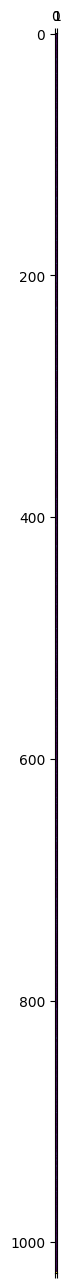

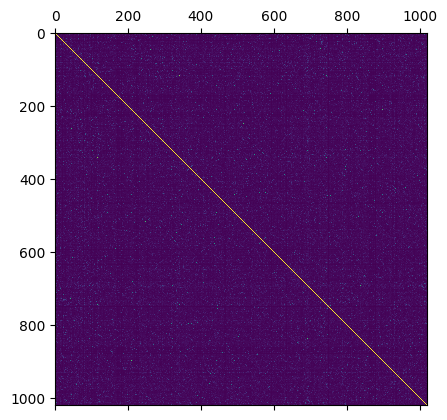

In [47]:
merged_df = pd.merge(df_fprint, tested, on='SMILES')

df = merged_df.copy()
single_value_columns = [col for col in df.columns if len(set(df[col])) == 1]
df.drop(single_value_columns, axis=1, inplace=True)

# Create correlation matrix
corr_matrix = df.corr().abs()
# print(corr_matrix.iloc[:, -1:])
print(max(corr_matrix["ERK2_inhibition"]))
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features with correlation greater than threshold
threshold = 0.8
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
# Drop features 
df.drop(to_drop, axis=1, inplace=True)
# Show changes to columns
print(f" Dropped {len(single_value_columns)} single value columns\n",
      f"Dropped {len(to_drop)} columns of higher than {threshold} correlation\n",
      f"Reduced data by {(len(df_desc_2d.columns) - len(df.columns)) / len(df_desc_2d.columns)*100:.2f}% to {len(df.columns)} columns")
# Show old and new correlation matrix
plt.matshow(merged_df.corr().abs().iloc[:, -2:])
plt.matshow(df.corr().abs())
plt.show()

In [51]:
from rdkit.Chem import PandasTools
from rdkit import DataStructs

In [283]:
esol_data = tested.copy()

ref_smiles = 'O=C(C1CCC1)N1CCc2cc(S(=O)(=O)Nc3ccc4c(c3)OCO4)ccc21'
ref_mol = Chem.MolFromSmiles(ref_smiles)
ref_ECFP4_fps = AllChem.GetMorganFingerprintAsBitVect(ref_mol,3)

PandasTools.AddMoleculeColumnToFrame(esol_data, smilesCol='SMILES')
bulk_ECFP4_fps = [AllChem.GetMorganFingerprintAsBitVect(x,3) for x in esol_data['ROMol']]

similarity_efcp4 = [DataStructs.FingerprintSimilarity(ref_ECFP4_fps,x) for x in bulk_ECFP4_fps]

esol_data['Tanimoto_Similarity (ECFP4)'] = similarity_efcp4
# PandasTools.FrameToGridImage(esol_data.head(8), legendsCol="Tanimoto_Similarity (ECFP4)", molsPerRow=4)

esol_data = esol_data.sort_values(['Tanimoto_Similarity (ECFP4)'], ascending=False)
# PandasTools.FrameToGridImage(esol_data.head(8), legendsCol="Tanimoto_Similarity (ECFP4)", molsPerRow=4)

esol_data.head(10)

,SMILES,PKM2_inhibition,ERK2_inhibition,ROMol,Tanimoto_Similarity (ECFP4)
1062,O=C(C1CCC1)N1CCc2cc(S(=O)(=O)Nc3ccc4c(c3)OCO4)...,1,0,<rdkit.Chem.rdchem.Mol object at 0x000001F089D...,1.000000
418,Cc1cc(Cl)c(S(=O)(=O)Nc2ccc3c(c2)OCO3)cc1OCC(N)=O,0,0,<rdkit.Chem.rdchem.Mol object at 0x000001F089D...,0.327273
1028,O=S(=O)(c1ccc(Nc2ccc3c(c2)OCO3)nc1)N1CCOCC1,0,0,<rdkit.Chem.rdchem.Mol object at 0x000001F089D...,0.299065
972,Cc1ccnc(N2CCC(C(=O)Nc3ccc4c(c3)OCO4)CC2)n1,0,0,<rdkit.Chem.rdchem.Mol object at 0x000001F089D...,0.290909
1064,O=C(OCc1ccc2c(c1)OCO2)c1ccc(S(=O)(=O)N2CCCC2)cc1,1,0,<rdkit.Chem.rdchem.Mol object at 0x000001F089D...,0.270270
711,O=C(CCc1nc2ccccc2[nH]1)Nc1ccc2c(c1)OCO2,0,0,<rdkit.Chem.rdchem.Mol object at 0x000001F089D...,0.258929
236,O=C(CN(c1ccc2c(c1)OCCO2)S(=O)(=O)c1ccccc1)Nc1c...,0,0,<rdkit.Chem.rdchem.Mol object at 0x000001F089D...,0.250000
1101,CCOc1cc(C(=O)Nc2ccc3c(c2)OCO3)ccc1OC(F)F,0,1,<rdkit.Chem.rdchem.Mol object at 0x000001F089D...,0.245614
789,CCC(CC)C(=O)Nc1cccc(C(=O)Nc2ccc3c(c2)OCO3)c1,0,0,<rdkit.Chem.rdchem.Mol object at 0x000001F089D...,0.243243
442,Cc1n[nH]c(C)c1S(=O)(=O)N1CCC[C@H](C(=O)Nc2ccc3...,0,0,<rdkit.Chem.rdchem.Mol object at 0x000001F089D...,0.239669


In [282]:
from rdkit.Chem import rdMolDescriptors

mqn_ds = [rdMolDescriptors.MQNs_(m) for m in mols]
col_name = [f'mqn_{i}' for i in range(1, len(mqn_ds[0]) + 1)]
# Create MQN dataframe where each column corresponds to a MQN feature
df_mqn = pd.DataFrame(data = mqn_ds, index = smiles, columns = col_name)

df_mqn

,mqn_1,mqn_2,mqn_3,mqn_4,mqn_5,mqn_6,mqn_7,mqn_8,mqn_9,mqn_10,...,mqn_33,mqn_34,mqn_35,mqn_36,mqn_37,mqn_38,mqn_39,mqn_40,mqn_41,mqn_42
SMILES,,,,,,,,,,,,,,,,,,,,,
C=C(C)c1nc(N)nc(N)n1,6,0,0,0,0,0,0,2,3,0,...,0,0,0,1,0,0,0,0,0,0
C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,13,0,1,0,0,0,0,0,0,2,...,0,0,0,2,0,0,0,0,2,1
C=CCNC(=O)CCCC(=O)NCC=C,11,0,0,0,0,0,0,2,0,2,...,0,0,0,0,0,0,0,0,0,0
C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,12,0,0,0,0,0,0,0,2,3,...,0,0,0,2,0,0,0,0,2,1
C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,10,0,1,0,0,0,0,0,2,2,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
O=C1c2ccccc2[C@H](Nc2ccc3c(c2)OCCO3)N1Cc1ccco1,21,0,0,0,0,0,0,1,1,1,...,0,0,2,3,0,0,0,0,4,2
O=S(=O)(Nc1cccc(-c2cn3ccsc3[nH+]2)c1)c1ccc(F)cc1,17,1,0,0,0,2,0,1,2,2,...,0,0,2,2,0,0,0,0,2,1
Oc1c(C[NH+]2CCN(c3ccccn3)CC2)cc(Cl)c2cccnc12,19,0,1,0,0,0,0,0,4,1,...,0,0,0,4,0,0,0,0,2,1


 Dropped 4 single value columns
 Dropped 6 columns of higher than 0.8 correlation
 Reduced data by 23.81% to 32 columns


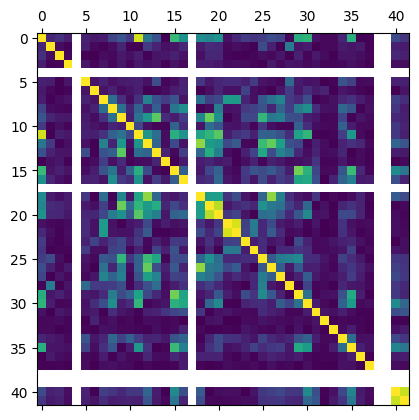

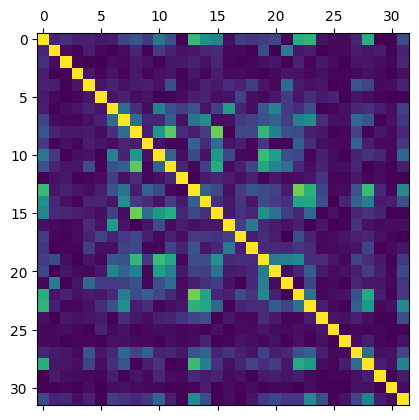

In [76]:
df = df_mqn.copy()
single_value_columns = [col for col in df.columns if len(set(df[col])) == 1]
df.drop(single_value_columns, axis=1, inplace=True)

# Create correlation matrix
corr_matrix = df.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features with correlation greater than threshold
threshold = 0.8
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
# Drop features 
df.drop(to_drop, axis=1, inplace=True)
# Show changes to columns
print(f" Dropped {len(single_value_columns)} single value columns\n",
      f"Dropped {len(to_drop)} columns of higher than {threshold} correlation\n",
      f"Reduced data by {(len(df_mqn.columns) - len(df.columns)) / len(df_mqn.columns)*100:.2f}% to {len(df.columns)} columns")
# Show old and new correlation matrix
plt.matshow(df_mqn.corr().abs())
plt.matshow(df.corr().abs())
plt.show()
# Copy cleaned df for saving
df_cleaned_mqn = df.copy()

In [77]:
df_cleaned_mqn.to_csv("data/cleaned_mqn.csv")

In [136]:
df_desc_2d.var().sort_values(ascending=True)["fr_Al_COO"]

0.03292026295064051

In [273]:
df_mqn.nunique(axis=0).sort_values(ascending=True).head(40)

mqn_18     1
mqn_39     1
mqn_5      1
mqn_40     1
mqn_38     2
mqn_34     2
mqn_33     2
mqn_7      2
mqn_37     2
mqn_15     3
mqn_4      3
mqn_3      3
mqn_24     3
mqn_25     3
mqn_8      4
mqn_32     4
mqn_23     5
mqn_35     5
mqn_29     5
mqn_11     5
mqn_6      5
mqn_28     6
mqn_22     6
mqn_14     7
mqn_2      7
mqn_36     7
mqn_10     8
mqn_9      9
mqn_21    10
mqn_42    10
mqn_26    12
mqn_27    13
mqn_41    13
mqn_19    13
mqn_31    15
mqn_17    16
mqn_20    17
mqn_13    19
mqn_30    22
mqn_16    23
dtype: int64

In [129]:
temp = df_cleaned_2d.copy()
drop_cols = [col for col in temp.columns if len(set(temp[col])) == 2]  # doesnt account for 1 or 0 values
# temp.drop(drop_cols, axis=1, inplace=True)
# print(len(temp.columns))
# temp.var()
print(drop_cols)

['fr_Al_COO', 'fr_C_S', 'fr_Imine', 'fr_barbitur', 'fr_dihydropyridine', 'fr_guanido', 'fr_lactam', 'fr_lactone', 'fr_nitro', 'fr_oxazole', 'fr_priamide', 'PKM2_inhibition', 'ERK2_inhibition']


In [130]:
for desc in drop_cols:
    print(MoleculeDescriptors.MolecularDescriptorCalculator([desc]).GetDescriptorSummaries())

['Number of aliphatic carboxylic acids']
['Number of thiocarbonyl']
['Number of Imines']
['Number of barbiturate groups']
['Number of dihydropyridines']
['Number of guanidine groups']
['Number of beta lactams']
['Number of cyclic esters (lactones)']
['Number of nitro groups']
['Number of oxazole rings']
['Number of primary amides']
['N/A']
['N/A']


In [149]:
df_cleaned_2d.loc[df_cleaned_2d['fr_priamide'] != 0]

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,PKM2_inhibition,ERK2_inhibition
SMILES,,,,,,,,,,,,,,,,,,,,,
CCn1c(SCC(=O)N2CCC(C(N)=O)([NH+]3CCCCC3)CC2)nnc1-c1ccccc1,12.929670,0.077434,-0.516554,0.604038,19.093750,457.624,0.278489,-0.364247,1.093750,32.166556,...,1,0,0,0,0,0,0,0,0,0
COc1ccc(-c2nc(CSCC(=O)N3CCC(C(N)=O)CC3)c(C)o2)cc1OC,12.426705,0.073317,-0.274754,0.681643,14.566667,433.530,0.232075,-0.492870,1.233333,32.166493,...,1,0,0,0,0,0,0,0,0,0
C[NH+]1CCN(S(=O)(=O)c2cccc(C(=O)Nc3sc4c(c3C(N)=O)CCCC4)c2)CC1,13.028932,0.097502,-3.669693,0.599019,17.838710,463.605,0.255825,-0.365496,1.161290,32.233444,...,0,1,0,0,0,1,0,0,0,0
CCCCCn1c(N2CCOCC2)nc2c1c(=O)n(CC(N)=O)c(=O)n2C,13.024439,0.322880,-0.737036,0.643644,14.814815,378.433,0.332463,-0.377774,1.185185,16.477636,...,0,0,0,0,0,0,1,0,0,0
COc1cc([C@@H]2C(C(N)=O)=C(C)Nc3nc(CCCO)nn32)cc(OC)c1OC,12.311771,0.039109,-0.631636,0.594406,15.551724,403.439,0.248419,-0.492703,1.241379,16.530054,...,0,0,0,0,0,0,0,0,0,0
COc1ccc([C@@H]2C(C(N)=O)=C(C)Nc3nc(-c4ccccc4)nn32)cc1OC,12.319562,0.411326,-0.547668,0.693005,15.482759,391.431,0.248419,-0.492870,1.103448,16.507823,...,0,0,0,0,0,0,0,0,0,0
COc1ccccc1[C@@H]1C(C(N)=O)=C(C)Nc2nc(-c3ccccc3Cl)nn21,12.289742,0.395934,-0.575335,0.705647,15.750000,395.850,0.248421,-0.496380,1.214286,35.495692,...,0,0,0,0,0,0,0,0,0,0
Cc1cc(Cl)c(S(=O)(=O)Nc2ccc3c(c2)OCO3)cc1OCC(N)=O,12.709442,0.015897,-4.013740,0.768517,12.692308,398.824,0.263020,-0.483469,1.269231,35.495694,...,0,1,0,0,0,0,0,0,0,0
Cc1ccccc1-n1c(Cn2c(=O)sc3ccccc32)nnc1SCC(N)=O,12.537211,0.049192,-0.425063,0.492116,11.178571,411.512,0.308068,-0.368947,1.142857,32.166599,...,1,0,0,0,1,0,0,0,0,0


In [156]:
g00 = tested.loc[(tested['PKM2_inhibition'] == 0) & (tested['ERK2_inhibition'] == 0)]
g01 = tested.loc[(tested['PKM2_inhibition'] == 0) & (tested['ERK2_inhibition'] == 1)]
g10 = tested.loc[(tested['PKM2_inhibition'] == 1) & (tested['ERK2_inhibition'] == 0)]
g11 = tested.loc[(tested['PKM2_inhibition'] == 1) & (tested['ERK2_inhibition'] == 1)]
print(f"""
Group 0-0 is legnth {len(g00)}
Group 0-1 is legnth {len(g01)}
Group 1-0 is legnth {len(g10)}
Group 1-1 is legnth {len(g11)}
""")


Group 0-0 is legnth 1038
Group 0-1 is legnth 50
Group 1-0 is legnth 27
Group 1-1 is legnth 1



[#6&R]:,-;@[#6&R]:,-;@[#6&R]:,-;@[#6&R]


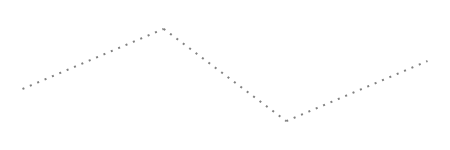

In [186]:
from rdkit.Chem import rdFMCS
smiles = g10["SMILES"]

mols = [Chem.MolFromSmiles(smi) for smi in smiles]

res = rdFMCS.FindMCS(mols, ringMatchesRingOnly=True)
print(res.smartsString)
res_mol = Chem.MolFromSmarts(res.smartsString)
res_mol

In [175]:
highlight_mcs = [mMol.GetSubstructMatch(res_mol) for mMol in mols]
# Draw.MolsToGridImage(mols, 
#                      highlightAtomLists = highlight_mcs,
#                      subImgSize=(250,250), useSVG=False, molsPerRow=4)

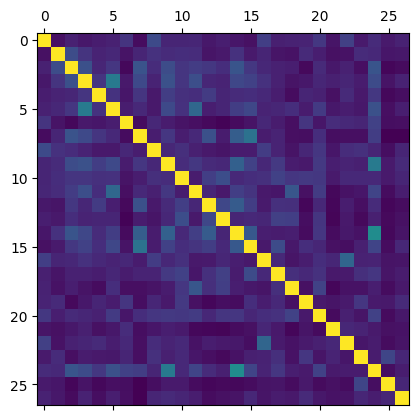

In [248]:
smiles = g10["SMILES"]

# Function to create grid of similarity scores within inhibitor groups
def similarity_grid(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    df_similarity = pd.DataFrame()

    for index, ref_smiles in enumerate(smiles):
        ref_mol = mols[index]  # Chem.MolFromSmiles(ref_smiles)
        ref_ECFP4_fps = AllChem.GetMorganFingerprintAsBitVect(ref_mol,2)

        bulk_ECFP4_fps = [AllChem.GetMorganFingerprintAsBitVect(x,2) for x in mols]

        similarity_efcp4 = pd.Series([DataStructs.FingerprintSimilarity(ref_ECFP4_fps,x) for x in bulk_ECFP4_fps])

        df_similarity = pd.concat((df_similarity, similarity_efcp4.rename(smiles)), axis=1)
    
    df_similarity.columns = smiles
    df_similarity.index = smiles
    plt.matshow(df_similarity)
    plt.show()
    return df_similarity

df_similarity = similarity_grid(smiles)

# Save result
# df_similarity.to_csv("data/similarity_10.csv")

In [272]:
df_similarity = pd.read_csv("data/similarity_10.csv").set_index("SMILES")
max_similarity_per_col = [df_similarity[col].nlargest(2).iloc[1] for col in df_similarity.columns]
max(max_similarity_per_col)

0.5081967213114754